# 读取相关库

In [12]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# 这里运行的时间有点长

def calculate_area(df):
    df["area"] = df["bbox"].apply(lambda x: eval(x)[2] * eval(x)[3])
    return df


def count_bbox_per_image(df):
    df['bbox_count'] = df.groupby('image_id')['image_id'].transform('count')
    return df


def get_source_onehot(source):
    sources = {
        'arvalis_1': [1, 0, 0, 0, 0, 0, 0],
        'arvalis_2': [0, 1, 0, 0, 0, 0, 0],
        'arvalis_3': [0, 0, 1, 0, 0, 0, 0],
        'inrae_1': [0, 0, 0, 1, 0, 0, 0],
        'ethz_1': [0, 0, 0, 0, 1, 0, 0],
        'rres_1': [0, 0, 0, 0, 0, 1, 0],
        'usask_1': [0, 0, 0, 0, 0, 0, 1],
    }
    return sources.get(source, [0, 0, 0, 0, 0, 0, 0])


def aggregate_data(df):
    df = df.groupby("image_id").agg({"bbox_count": "first", "area": list, "source": lambda x: get_source_onehot(x.values[0])}).reset_index()
    return df


def extract_image_features(image_path):
    image = cv2.imread(image_path)
    image_feayures = {"color_mean": np.mean(image, axis=(0, 1)), "color_std": np.std(image, axis=(0, 1)), "image": image}
    return image_feayures


def process_image_data(df):
    df['image_features'] = df['image_id'].apply(lambda x: extract_image_features(f"/Users/wyx/程序/外包项目/WheatDetection/data/train/{x}.jpg"))
    # 保存为列表格式
    df['image_features1'] = df['image_features'].apply(lambda x: x.get("color_mean").tolist())
    df['image_features2'] = df['image_features'].apply(lambda x: x.get("color_std").tolist())
    return df


# 分块读取数据并处理
chunksize = 100
for chunk in pd.read_csv('/Users/wyx/程序/外包项目/WheatDetection/data/train.csv', chunksize=chunksize):
    chunk = calculate_area(chunk)
    chunk = count_bbox_per_image(chunk)
    chunk = aggregate_data(chunk)
    chunk = process_image_data(chunk)
    chunk = chunk.drop(columns=['image_features'])
    # 添加列名
    chunk.to_csv('./data/kmeans_data.csv', mode='a', header=False, index=False)
# 存储列名
with open('./data/kmeans_data.csv', 'r') as f:
    lines = f.readlines()
with open('./data/kmeans_data.csv', 'w') as f:
    f.write('image_id,bbox_count,area,source,image_features1,image_features2,image\n')
    f.writelines(lines)


In [81]:
import ast

kmeans_data = pd.read_csv('./data/kmeans_data.csv')
kmeans_data_area = kmeans_data['area'].apply(lambda x: ast.literal_eval(x))
area_max_length = kmeans_data_area.apply(lambda x: len(x)).max()
kmeans_data_area = kmeans_data_area.apply(lambda x: x + [0] * (area_max_length - len(x)))
area_columns = pd.DataFrame(kmeans_data_area.tolist(), columns=[f'area_{i}' for i in range(area_max_length)])
image_features1_columns = pd.DataFrame(kmeans_data['image_features1'].apply(lambda x: ast.literal_eval(x)).tolist(), columns=[f'image_features1_{i}' for i in range(3)])
image_features2_columns = pd.DataFrame(kmeans_data['image_features2'].apply(lambda x: ast.literal_eval(x)).tolist(), columns=[f'image_features2_{i}' for i in range(3)])
source_columns = pd.DataFrame(kmeans_data['source'].apply(lambda x: ast.literal_eval(x)).tolist(), columns=[f'source_{i}' for i in range(7)])
kmeans_data = pd.concat([kmeans_data, area_columns, image_features1_columns, image_features2_columns, source_columns], axis=1)
kmeans_data = kmeans_data.drop(columns=['area', 'image_features1', 'image_features2', 'image_id', 'image', "source"])

In [82]:
kmeans_data

,bbox_count,area_0,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,...,image_features2_0,image_features2_1,image_features2_2,source_0,source_1,source_2,source_3,source_4,source_5,source_6
0,7,5650.0,1054.0,3445.0,9860.0,7372.0,7728.0,5712.0,0.0,0.0,...,30.117193,42.988477,43.691022,0,0,0,0,0,0,1
1,46,3456.0,6650.0,2990.0,5400.0,5616.0,3773.0,6480.0,11352.0,5624.0,...,40.529284,48.660379,50.775043,0,0,0,0,0,0,1
2,47,2016.0,7540.0,11840.0,11663.0,14508.0,13209.0,3690.0,9150.0,5576.0,...,28.456202,41.025763,42.274759,0,0,0,0,0,0,1
3,33,8103.0,8140.0,8084.0,11988.0,13572.0,8910.0,145360.0,9450.0,7200.0,...,45.203074,52.799188,52.684089,0,0,0,0,0,0,1
4,34,5740.0,13625.0,5040.0,7938.0,16100.0,12300.0,8836.0,9360.0,9900.0,...,30.117193,42.988477,43.691022,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4812,19,10396.0,9660.0,11155.0,11397.0,6264.0,4032.0,17460.0,7505.0,8690.0,...,58.052056,63.955433,62.371629,0,1,0,0,0,0,0
4813,10,8924.0,12528.0,11730.0,5244.0,6930.0,11562.0,38608.0,7738.0,29475.0,...,56.105545,65.120843,62.865845,0,1,0,0,0,0,0
4814,25,10170.0,11972.0,8400.0,6675.0,11152.0,14490.0,4968.0,10368.0,22984.0,...,54.541709,59.124064,60.156844,0,1,0,0,0,0,0
4815,23,5586.0,10580.0,11115.0,10906.0,8214.0,2730.0,3672.0,5060.0,8670.0,...,60.175368,62.867699,61.832953,0,1,0,0,0,0,0


/Users/wyx/miniconda3/envs/wheat/lib/python3.10/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


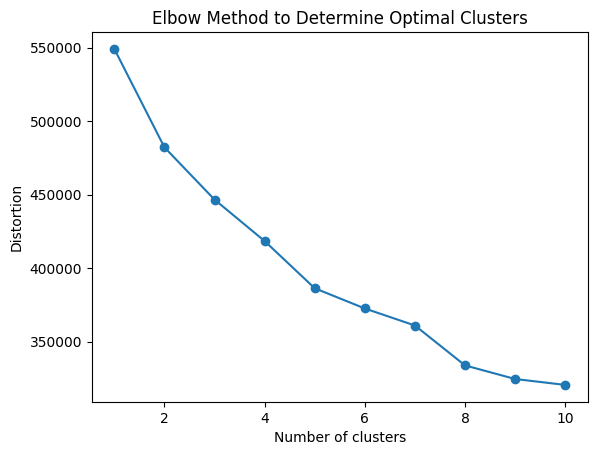

In [83]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 提取所有列为特征列
X = kmeans_data.values

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)

# 绘制肘部法则图表
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()

In [84]:
# 初始化并训练KMeans模型
kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(X_scaled)

# 获取每个样本的簇标签
cluster_labels = kmeans.labels_

# 将簇标签添加回原始数据
kmeans_data['cluster_label'] = cluster_labels

# 查看每个簇的中心点
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print(cluster_centers)


[[ 7.30457143e+01  6.25337714e+03  6.08309143e+03  6.33198857e+03
   6.36048000e+03  6.10400571e+03  5.92205143e+03  6.21261080e+03
   6.05477143e+03  6.01826286e+03  6.09741714e+03  5.60478926e+03
   6.09740000e+03  6.53364000e+03  6.00585143e+03  5.72828000e+03
   5.39486857e+03  5.67261143e+03  5.60444571e+03  5.82346674e+03
   5.80082377e+03  5.00235371e+03  5.69446857e+03  5.21053714e+03
   5.09937714e+03  4.76041714e+03  4.83177143e+03  5.05806057e+03
   5.09345714e+03  5.32912486e+03  4.86364000e+03  4.62978286e+03
   4.99964194e+03  4.62676000e+03  4.77661943e+03  5.03661971e+03
   5.02246234e+03  4.63727429e+03  4.61142069e+03  4.64338286e+03
   4.69393909e+03  4.70065469e+03  4.77132486e+03  4.62117714e+03
   4.18546960e+03  4.44387429e+03  4.34588474e+03  4.27611429e+03
   4.06768571e+03  4.09514286e+03  4.06692400e+03  4.30518126e+03
   3.88036571e+03  4.26501377e+03  4.20676114e+03  4.05281714e+03
   3.89922343e+03  4.40911914e+03  4.10389143e+03  4.01700520e+03
   3.96960

In [90]:
# 读取原始数据，并和预测结果进行拼接
original_kmeans_data = pd.read_csv('./data/kmeans_data.csv')
finally_kmeans_data = pd.concat([original_kmeans_data, kmeans_data['cluster_label']], axis=1)
finally_kmeans_data

,image_id,bbox_count,area,source,image_features1,image_features2,image,cluster_label
0,7b72ea0fb,7,"[5650.0, 1054.0, 3445.0, 9860.0, 7372.0, 7728....","[0, 0, 0, 0, 0, 0, 1]","[55.106276512145996, 70.63884925842285, 70.051...","[30.117192751234573, 42.98847694287577, 43.691...",NaN,4
1,b53afdf5c,46,"[3456.0, 6650.0, 2990.0, 5400.0, 5616.0, 3773....","[0, 0, 0, 0, 0, 0, 1]","[76.72650337219238, 81.86239624023438, 86.3120...","[40.52928447570435, 48.66037857096145, 50.7750...",NaN,2
2,b6ab77fd7,47,"[2016.0, 7540.0, 11840.0, 11663.0, 14508.0, 13...","[0, 0, 0, 0, 0, 0, 1]","[59.53560161590576, 74.99213123321533, 77.0143...","[28.45620208049269, 41.02576272233652, 42.2747...",NaN,1
3,41c0123cc,33,"[8103.0, 8140.0, 8084.0, 11988.0, 13572.0, 891...","[0, 0, 0, 0, 0, 0, 1]","[62.99142837524414, 70.2148666381836, 71.80941...","[45.20307372165576, 52.799187707914825, 52.684...",NaN,5
4,7b72ea0fb,34,"[5740.0, 13625.0, 5040.0, 7938.0, 16100.0, 123...","[0, 0, 0, 0, 0, 0, 1]","[55.106276512145996, 70.63884925842285, 70.051...","[30.117192751234573, 42.98847694287577, 43.691...",NaN,2
...,...,...,...,...,...,...,...,...
4812,5e0747034,19,"[10396.0, 9660.0, 11155.0, 11397.0, 6264.0, 40...","[0, 1, 0, 0, 0, 0, 0]","[80.83440971374512, 115.86784362792969, 109.72...","[58.052055625352686, 63.955432694301784, 62.37...",NaN,5
4813,990c1777d,10,"[8924.0, 12528.0, 11730.0, 5244.0, 6930.0, 115...","[0, 1, 0, 0, 0, 0, 0]","[68.08008098602295, 105.4214334487915, 91.0581...","[56.105544599077874, 65.12084299996795, 62.865...",NaN,4
4814,a5c8d5f5c,25,"[10170.0, 11972.0, 8400.0, 6675.0, 11152.0, 14...","[0, 1, 0, 0, 0, 0, 0]","[81.83931541442871, 119.35826396942139, 120.40...","[54.541708850342864, 59.12406426341178, 60.156...",NaN,5
4815,bce2fdc4d,23,"[5586.0, 10580.0, 11115.0, 10906.0, 8214.0, 27...","[0, 1, 0, 0, 0, 0, 0]","[90.10549259185791, 126.17830848693848, 128.75...","[60.175368276288474, 62.86769944176535, 61.832...",NaN,4


In [92]:
finally_kmeans_data.to_csv('./data/finally_kmeans_data.csv', header=True, index=False)